# Importing Libraries

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import color
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
import gc

## Hyperparameters

In [2]:
learning_rate = 1e-04
num_epochs = 10
batch_size = 8
img_resize = 1024
crop_size = 512
mean, std = [0.4194, 0.4612, 0.3479], [0.2038, 0.1898, 0.2043]
inv_transforms = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                        std = [ 1/std[0], 1/std[1], 1/std[2] ]),
                                    transforms.Normalize(mean = [-mean[0], -mean[1], -mean[2]],
                                        std = [ 1., 1., 1. ])])
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Helper Functions

In [3]:
# Calculate mean and std_dev for normalization
def mean_and_std(dataloader):
    channel_sum, channel_squared_sum = 0, 0
    for idx, (imgs, _) in tqdm(enumerate(dataloader, start = 1), total=len(dataloader)):
        imgs = imgs.to(device, non_blocking = True)
        channel_sum += torch.mean(imgs, dim = [0, 2, 3])
        channel_squared_sum += torch.mean(imgs**2, dim = [0, 2, 3])
    mean = channel_sum / (idx)
    std = (channel_squared_sum/(idx) - mean**2)**0.5
    return mean, std

## Loading data

In [4]:
base_data_dir = pathlib.Path('data/FloodNet-Supervised_v1.0/')
train_dir = base_data_dir/'train'
test_dir = base_data_dir/'test'
valid_dir = base_data_dir/'val'
train_img_dir, train_mask_dir = train_dir/'train-org-img', train_dir/'train-label-img'
valid_img_dir, valid_mask_dir = valid_dir/'val-org-img', valid_dir/'val-label-img'
test_img_dir, test_mask_dir = test_dir/'test-org-img', test_dir/'test-label-img'

In [5]:
# Fetching all the jpgs from the img folder
# the glob module is used to retrieve files/pathnames matching a specified pattern
train_images = list(train_img_dir.glob('*.jpg'))
valid_images = list(valid_img_dir.glob('*.jpg'))
test_images = list(test_img_dir.glob('*.jpg'))
print(f"No of Train Images: {len(train_images)}, No of Valid Images: {len(valid_images)}, No of Test Images: {len(test_images)}")
train_images[:5]

No of Train Images: 1445, No of Valid Images: 450, No of Test Images: 448


[PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/9036.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/6525.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/10182.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/7037.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/6992.jpg')]

In [6]:
def label_mask_path(mask_dir, image_path):
    return mask_dir/f'{image_path.stem}_lab.png'
idx = 42
img_path = train_images[idx]
label_path = label_mask_path(train_mask_dir, img_path)
print(img_path)
print(label_path)

data/FloodNet-Supervised_v1.0/train/train-org-img/6960.jpg
data/FloodNet-Supervised_v1.0/train/train-label-img/6960_lab.png


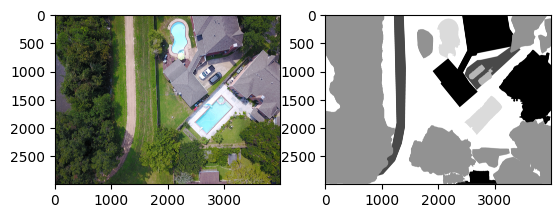

In [7]:
plt.subplot(121)
img = Image.open(img_path)
img = np.asarray(img)
plt.imshow(img)
plt.subplot(122)
mask = Image.open(label_path)
mask = np.asarray(mask)
plt.imshow(mask, cmap = 'gray');

In [ ]:
unique_labels = []
for img in tqdm(train_images):
    mask_path = label_mask_path(train_mask_dir, img)
    mask = np.asarray(Image.open(mask_path))
    unique_label = np.unique(mask).tolist()
    unique_labels.extend(unique_label)
print(f"No of unique labels: {len(set(unique_labels))}")

In [8]:
class SatelliteDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, images, transforms = None):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.images = images
        self.transforms = transforms

    def __len__(self):
        return len(self.images)
         
    def __getitem__(self, idx):
        current_img_path = self.images[idx]
        current_label_path = self.label_mask_path(current_img_path)
        img = np.asarray(Image.open(current_img_path)).copy() / 255.
        mask = np.asarray(Image.open(current_label_path)).copy()
        if self.transforms:
            transformed = self.transforms(image = img, mask = mask)
            img = transformed['image']
            mask = transformed['mask']
        return img, mask

    def label_mask_path(self, image_path):
        return self.masks_dir/f'{image_path.stem}_lab.png'

In [9]:
train_augmentation = A.Compose([A.LongestMaxSize(max_size=img_resize, interpolation=1),
                                A.RandomCrop(height = crop_size, width = crop_size),
                                A.Normalize(mean = mean, std = std, max_pixel_value=1),
                                ToTensorV2(),
                                ])
train_dataset = SatelliteDataset(train_img_dir, train_mask_dir, train_images, train_augmentation)
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=8, pin_memory=True)

In [10]:
print('No. of batches in train loader = ',len(trainloader))
print ('Size of training dataset = ',len(train_dataset) )

No. of batches in train loader =  181
Size of training dataset =  1445


In [11]:
# mean_and_std(trainloader)

In [12]:
test_augmentation = A.Compose([A.LongestMaxSize(max_size=img_resize, interpolation=1),
                                A.RandomCrop(height = crop_size, width = crop_size),
                                A.Normalize(mean = mean, std = std, max_pixel_value=1),
                                ToTensorV2(),
                                ])
test_dataset = SatelliteDataset(test_img_dir, test_mask_dir, test_images, test_augmentation)
testloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8, pin_memory=True)

In [13]:
print ('No. of batches in test loader = ',len(testloader))
print ('Size of training dataset = ',len(test_dataset) )

No. of batches in test loader =  56
Size of training dataset =  448


In [14]:
train_imgs, train_masks = next(iter(trainloader))
train_imgs.shape, train_masks.shape

(torch.Size([8, 3, 512, 512]), torch.Size([8, 512, 512]))

In [15]:
test_imgs, test_masks = next(iter(testloader))
test_imgs.shape, test_masks.shape

(torch.Size([8, 3, 512, 512]), torch.Size([8, 512, 512]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


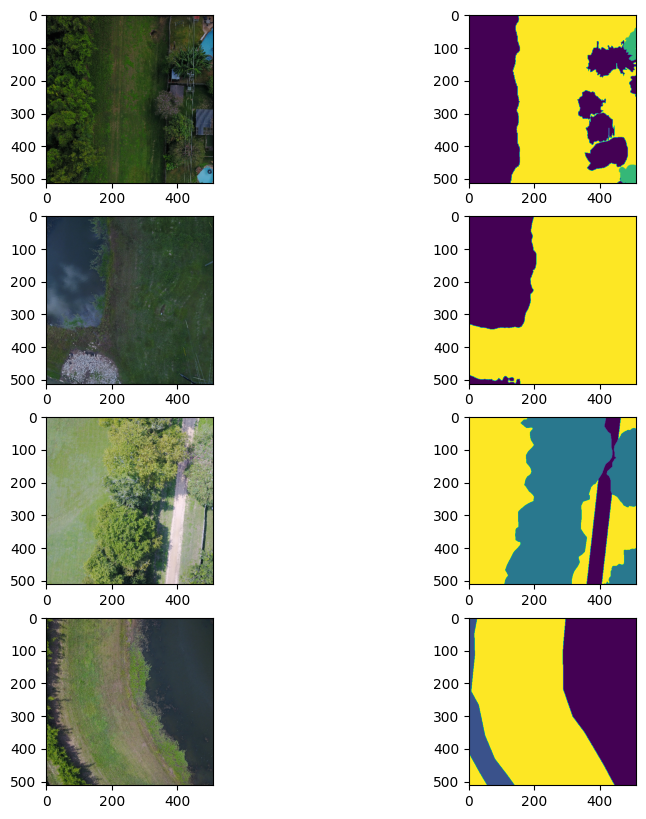

In [16]:
fig, axes = plt.subplots(4, 2, figsize = (10,10))
for i in range(4):
    # (H x W x C) -> (C x H x W)
    # Denormalizing input
    img = inv_transforms(train_imgs[i])
    img, mask = np.transpose(img.cpu().detach(), (1,2,0)), train_masks[i]
    axes[i, 0].imshow(img)
    #axes[i, 0].axis('off')
    axes[i, 1].imshow(mask)
    #axes[i, 1].axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


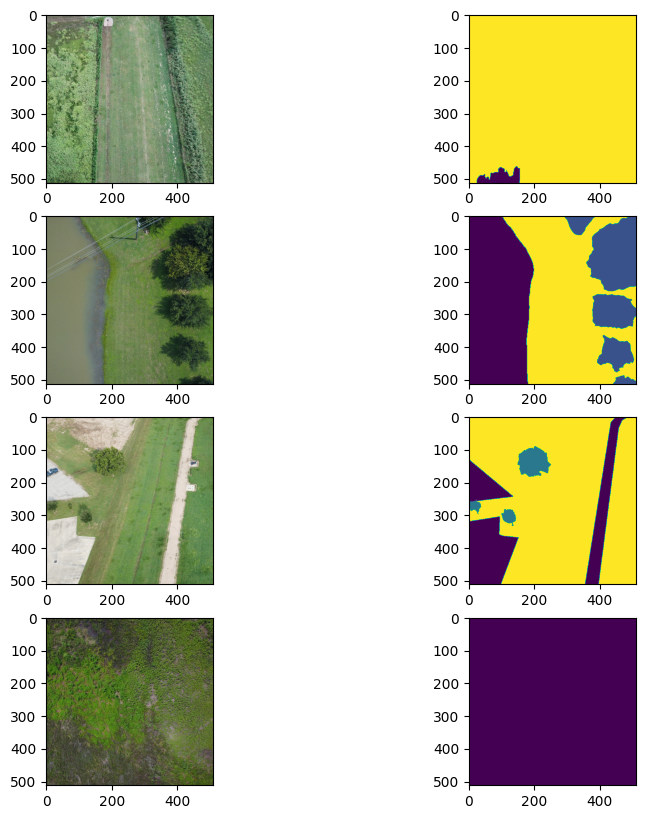

In [17]:
fig, axes = plt.subplots(4, 2, figsize = (10,10))
for i in range(4):
    # (H x W x C) -> (C x H x W)
    img = inv_transforms(test_imgs[i])
    img, mask = np.transpose(img.cpu().detach(), (1,2,0)), test_masks[i]
    axes[i, 0].imshow(img)
    #axes[i, 0].axis('off')
    axes[i, 1].imshow(mask)
    #axes[i, 1].axis('off')

In [18]:
for img,mask in (trainloader):
    break
print ("For one batch \nImage Shape = ",img.shape)
print ("Mask shape = ",mask.shape)

For one batch 
Image Shape =  torch.Size([8, 3, 512, 512])
Mask shape =  torch.Size([8, 512, 512])


### Segmentation Model

In [19]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()
        self.arc = smp.Unet(encoder_name = 'resnet34', encoder_weights = 'imagenet', classes = 10)

    def forward(self, images):
        logits = self.arc(images)
        return logits

### Train and Test Function 

In [20]:
def train_fn(data_loader, model, optimizer, criterion, train = True):
    model.train()
    total_loss = 0.0
    pbar = tqdm(data_loader, total = len(data_loader), leave=False)
    for imgs,masks in pbar:
        imgs = imgs.to(device, non_blocking = True)
        masks = masks.to(device, non_blocking = True).to(torch.int64)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, masks)
        if train:
            loss.backward()
            optimizer.step()
        pbar.set_postfix({'Loss': loss.item()})
        total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    return avg_loss

## Model Building

In [21]:
model = SegmentationModel()
model = model.to(device)
criterion = DiceLoss(mode = 'multiclass',classes=10)
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

### Training model

In [22]:
best_test_loss = np.Inf
for i in range(num_epochs):
    train_loss = train_fn (trainloader, model, optimizer, criterion, train = True)
    torch.cuda.empty_cache()
    gc.collect()
    test_loss = train_fn (testloader, model, optimizer, criterion, train = False)
    if test_loss < best_test_loss:
        torch.save(model.state_dict(),'Best Model.pt')
        print("Model Saved")
        best_test_loss = test_loss
    print (f"Epoch : {i+1} Train Loss = {train_loss} Test Loss = {test_loss}")

Model Saved
Epoch : 1 Train Loss = 0.5902690327628541 Test Loss = 0.5325490308127233


Model Saved
Epoch : 2 Train Loss = 0.4494573456641719 Test Loss = 0.41805687293942484


Model Saved
Epoch : 3 Train Loss = 0.3726275298970839 Test Loss = 0.3770045968038695


Model Saved
Epoch : 4 Train Loss = 0.3486083288424911 Test Loss = 0.3411183003336191


Model Saved
Epoch : 5 Train Loss = 0.29281820297158884 Test Loss = 0.33393598441034555


Model Saved
Epoch : 6 Train Loss = 0.2948869370047559 Test Loss = 0.31339999933594037


Model Saved
Epoch : 7 Train Loss = 0.2816878327410359 Test Loss = 0.29997129139623474


Model Saved
Epoch : 8 Train Loss = 0.24443870563142372 Test Loss = 0.266949954642249


Model Saved
Epoch : 9 Train Loss = 0.22766877377395472 Test Loss = 0.25400419985609396


Epoch : 10 Train Loss = 0.22721213042653726 Test Loss = 0.2589753220922181


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


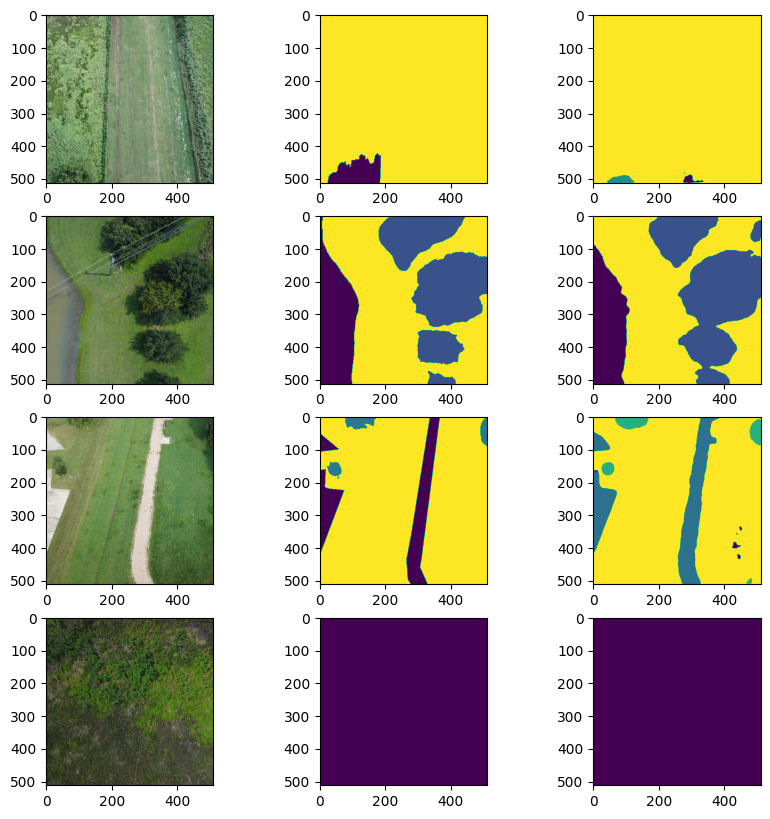

In [35]:
imgs, masks = next(iter(testloader))
imgs = imgs.to(device)
preds = model(imgs)
fig, axes = plt.subplots(4, 3, figsize = (10,10))
for i in range(4):
    # (H x W x C) -> (C x H x W)
    # Denormalizing input
    img = inv_transforms(imgs[i])
    img, mask = np.transpose(img.cpu().detach(), (1,2,0)), masks[i]
    axes[i, 0].imshow(img)
    #axes[i, 0].axis('off')
    axes[i, 1].imshow(mask)
    #axes[i, 1].axis('off')
    _, pred_mask = torch.max(preds[i], dim = 0)
    pred_mask = pred_mask.cpu().detach()
    axes[i, 2].imshow(pred_mask)